In [83]:
import pandas as pd
from bs4 import BeautifulSoup
import nltk, re, pprint
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer
from collections import defaultdict 
from nltk.corpus import wordnet as wn
from itertools import chain
from difflib import get_close_matches as gcm
import re
from textblob import TextBlob, Word
import time
from collections import Counter

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator # to create a Word Cloud
from matplotlib import pyplot as plt

In [84]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/marco/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/marco/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/marco/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [85]:
df_raw = pd.read_csv('/home/marco/Documents/OC_Machine_learning/section_5/tags_stackoverflow/data-output/QueryResults.csv', parse_dates=['CreationDate']) #import raw data from the csv obtained by SQL query
df_raw.Date=pd.to_datetime(df_raw.CreationDate) # set creation date as date and time object


/home/marco/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


In [86]:
df_raw['Body_clean'] = [BeautifulSoup(text).get_text() for text in df_raw['Body'] ] # get text in html body

In [87]:
pattern = "<(.*?)>" # indicate to regex the pattern for angle brackets: < >
df_raw['Tags_clean'] = [re.findall(pattern, text) for text in df_raw['Tags'] ] # get text within the square brackets as list entries

In [88]:
# set all text in body to lower case
df_raw['Body_clean'] = df_raw['Body_clean'].str.lower() 


In [89]:
# remove stopwords from the Body 
stop_words = stopwords.words('english')
new_stopwords = ["n't", 've', 'words']
stop_words.extend(new_stopwords)
stop_words = set(stop_words)


df_raw['Body_clean'] = df_raw['Body_clean'].apply(lambda x: [item for item in word_tokenize(x) if item not in stop_words]) # remove stopwords from tokens

In [90]:
#remove numbers from the Body 
  
# Decorator to Remove all digits from a list of string 
def remove(list): 
    pattern1 = '[0-9]'
    list = [re.sub(pattern1, '', i) for i in list] 
    return list
# Driver code 
df_raw['Body_clean'] = [remove(text) for text in df_raw['Body_clean'] ]

In [91]:
#remove punctuation from the Body 

# Decorator to remove punctuation from a list of string 
def remove1(list): 
    pattern2 = '[?.!/;:]'
    list = [re.sub(pattern2, '', i) for i in list] 
    return list
# Driver code 
df_raw['Body_clean'] = [remove1(text) for text in df_raw['Body_clean'] ]

In [92]:
df_raw['liststring'] = [' '.join(map(str, l)) for l in df_raw['Body_clean']] # transform lists to strings to be able to run lemmatization
#df_raw.head()

In [93]:
# Define function to lemmatize each word with its POS tag
def lemmatize_with_postag(sentence):
    sent = TextBlob(sentence)
    tag_dict = {"J": 'a', 
                "N": 'n', 
                "V": 'v', 
                "R": 'r'}
    words_and_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags]    
    lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]
    return " ".join(lemmatized_list)

In [94]:
time_start = time.time()

# Lemmatizing
df_raw['Body_lemma'] = df_raw['liststring'].apply(lemmatize_with_postag)
print('Lemmatization done! Time elapsed: {} seconds'.format(time.time()-time_start))

Lemmatization done! Time elapsed: 211.40505051612854 seconds


In [95]:
cleanfeatures = ['ViewCount', 'CreationDate', 'Body_lemma','Tags_clean', 'Score', 'CommentCount', 'AnswerCount', 'FavoriteCount']
df_clean = df_raw[cleanfeatures]

In [96]:
df_clean.rename(columns={'Body_lemma':'body', 'Tags_clean':'tags'},inplace=True)
df_clean.head()

/home/marco/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,ViewCount,CreationDate,body,tags,Score,CommentCount,AnswerCount,FavoriteCount
0,1483128,2012-06-27 13:51:36,piece c++ code show peculiar behavior strange ...,"[java, c++, performance, optimization, branch-...",24320,22,26,10983
1,8547399,2009-05-29 18:09:14,accidentally commit wrong file git push commit...,"[git, version-control, git-commit, undo, pre-c...",20895,13,83,6776
2,8115583,2010-01-05 01:12:15,want delete branch locally remotely fail attem...,"[git, version-control, git-branch, git-push, g...",16826,6,40,5357
3,2782271,2008-11-15 09:51:09,difference git pull git fetch,"[git, version-control, git-pull, git-fetch]",11833,9,35,2333
4,2783219,2009-01-25 15:25:19,'ve mess around json time push text hurt anybo...,"[json, http-headers, content-type]",10204,0,36,1446


In [102]:
count_body = df_clean['body'].value_counts()
uniquewords_body = df_clean['body'].unique()
print(len(uniquewords_body), len(count_body))

37175 37175


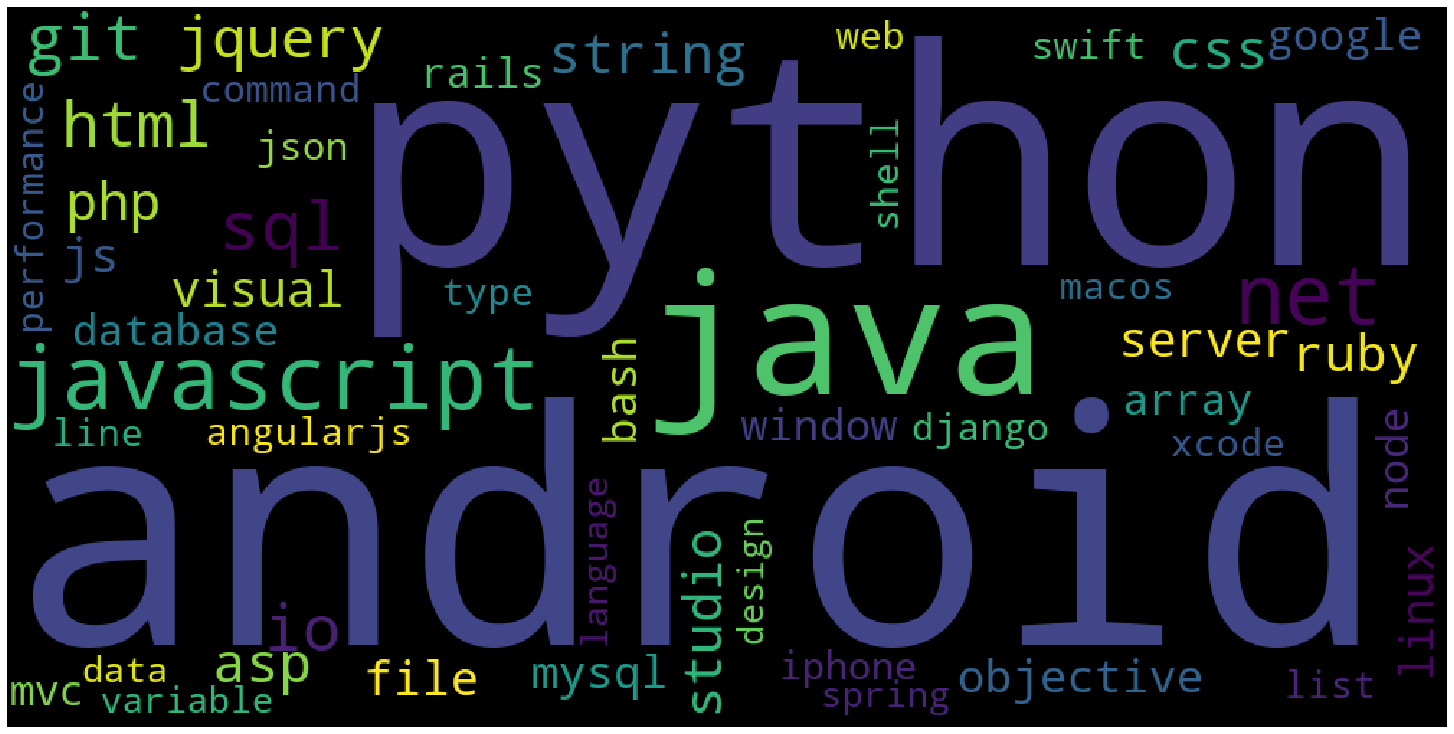

In [103]:
soup = ' '.join(uniquewords_body)
WordCloud(background_color="white", width=1000, height=500,max_words=50, collocations=False).generate(soup)
plt.figure(figsize=(20,10),facecolor='w')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [99]:
df_clean['taglist'] = [' '.join(map(str, l)) for l in df_clean['tags']] # transform lists to strings to be able to run lemmatization

/home/marco/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [100]:
count_tags = df_clean['taglist'].value_counts()
uniquewords_tags = df_clean['taglist'].unique()
print(len(uniquewords_tags), len(count_tags))

27321 27321


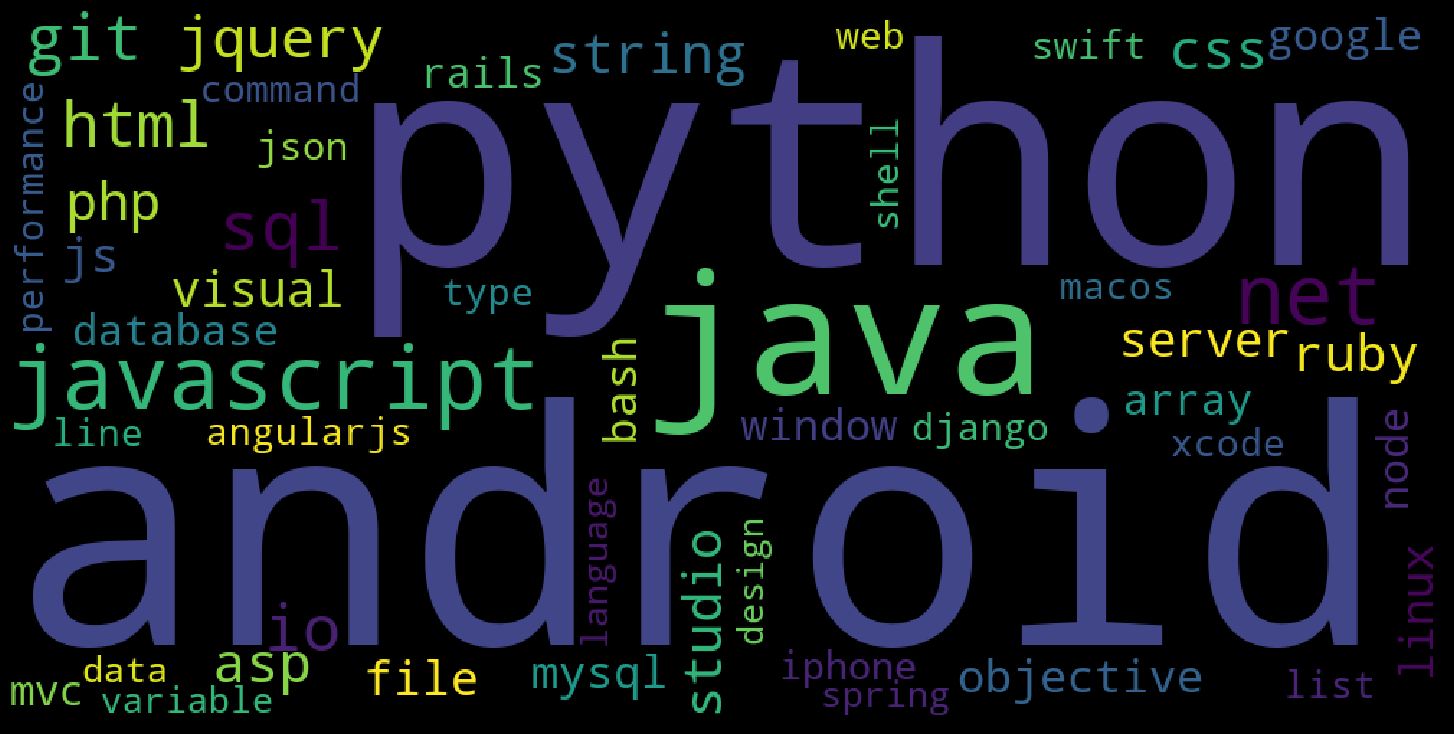

In [101]:
soup = ' '.join(uniquewords_tags)
#wordcloud = WordCloud().generate()

wordcloud = WordCloud(width=1000, height=500,max_words=50, collocations=False)
wordcloud.generate(soup)
plt.figure(figsize=(20,10),facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()